In [229]:
import pandas as pd
import seaborn as sns
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
import nltk as nltk
import bz2
import json
import datetime
from iteration_utilities import deepflatten
import nltk as nltk
import scipy.stats as stats
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
pd.options.mode.chained_assignment = None
from helpers import add_time, week, weekday_number, weekday, month, add_dict, to_dict, get_media, find_media
sns.set_theme(context='notebook', style='white')
plt.tight_layout()
from textblob import TextBlob
from chart_studio import plotly
import plotly.express as px

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\asbjo\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


<Figure size 432x288 with 0 Axes>

In [230]:
# Filepaths 

#Cleaned files from M2
path_to_file = ['quotes-2015.json-001.bz2','quotes-2016.json-002.bz2','quotes-2017.json.bz2',
                  'quotes-2018-004.json.bz2','quotes-2019-005.json.bz2','quotes-2020.json.bz2']

# Path to files after adding media and remove unnesceceray columns
files_with_sentiment = ['clean-quotes-2015_with_sentiment.csv.bz2','clean-quotes-2016_with_sentiment.csv.bz2','clean-quotes-2017_with_sentiment.csv.bz2',
                  'clean-quotes-2018_with_sentiment.csv.bz2','clean-quotes-2019_with_sentiment.csv.bz2','clean-quotes-2020_with_sentiment.csv.bz2']

In [231]:
# The media outlets that will be taken into concern for the project

media_outlets = ['nytimes', 'wsj', 'womansday', 'nbcnews', 'foxnews', 'aarp', 'usmagazine', 'espn', 'usatoday', 
'newstoday', 'sportingnews', 'theguardian', 'people', 'tmz', 'mtv', 'cnn', 'msn', 'reuters', 'timesrepublican', 
'nationalgeographic', 'latimes', 'washingtonpost', 'startribune', 'chicagotribune', 'usnews', 'theathletic', 
'rollingstone', 'vanityfair', 'intouchweekly', 'starmagazine', 'bbc', 'independent', 'thesun', 'thetimes',
'express', 'dailymail', 'mirror', 'economist', ]


#Same media oulets sorted by category
newspapers = ['nytimes', 'wsj','foxnews', 'aarp','usatoday', 'newstoday', 'reuters', 'timesrepublican', 
'latimes', 'washingtonpost', 'startribune', 'cnn',  'chicagotribune', 'usnews', 'nbcnews', 'theguardian',
'bbc', 'independent', 'thesun', 'thetimes','express', 'dailymail', 'mirror', 'economist']

celebmagazines = ['usmagazine', 'people','tmz', 'intouchweekly', 'starmagazine']

other = ['mtv', 'msn','nationalgeographic', 'vanityfair', 'rollingstone', 'womansday']

sport = ['espn', 'sportingnews', 'theathletic']



In [232]:
# Initializing a sentiment analyzer
sent_analyzer = SentimentIntensityAnalyzer()

#Iterating through the cleaned files
for x in range(len(path_to_file)):
# Reading the data in chunks
  df_reader = pd.read_json(path_to_file[x], lines=True, compression='bz2', chunksize=500000)
  for chunk in df_reader:

    #Dropping unnecesary columns
    chunk = chunk.drop(axis=1, columns = 'quoteID')
    chunk = chunk.drop(axis=1, columns = 'phase')
    chunk = chunk.drop(axis=1, columns = 'speaker')
    chunk = chunk.drop(axis=1, columns = 'qids')
    chunk = chunk.drop(axis=1, columns = 'numOccurrences')
    chunk = chunk.drop(axis=1, columns = 'probas')
    
    #Adding media outlet if substring found in url
    chunk = get_media(chunk, media_outlets)
    
    # Dropping NaN values in media_outlet
    chunk = chunk.dropna(axis=0, subset=['media_outlet'])
    chunk = chunk.drop(axis=1, columns = 'urls')

    # Calculating compound sentiment scores for the chunk and append the values in a column
    chunk['compound'] = chunk['quotation'].apply(lambda x: sent_analyzer.polarity_scores(x)['compound'])
    chunk['positive'] = chunk['quotation'].apply(lambda x: sent_analyzer.polarity_scores(x)['pos'])
    chunk['negative'] = chunk['quotation'].apply(lambda x: sent_analyzer.polarity_scores(x)['neg'])
    chunk['blob_polar'] = chunk['quotation'].apply(lambda x: TextBlob(x).sentiment.polarity)
    chunk['blob_subj'] = chunk['quotation'].apply(lambda x: TextBlob(x).sentiment.subjectivity)
    chunk = chunk.drop(axis=1, columns = 'quotation')

    #Adding date_short
    chunk['date_short'] = pd.to_datetime(chunk['date']).dt.date
    chunk = chunk.drop(axis=1, columns = 'date')
    
    #Writing chunk to csv
    chunk.to_csv(path_or_buf= files_with_sentiment[x], compression='bz2', mode = 'a')
    print('chunk OK')


FileNotFoundError: [Errno 2] No such file or directory: 'quotes-2015.json-001.bz2'

## Start media analysis

In [ ]:
# Files with media
files = ['media_outlet_with_sentiment/clean-quotes-2015_with_sentiment.csv.bz2',
    'media_outlet_with_sentiment/clean-quotes-2016_with_sentiment.csv.bz2',
    'media_outlet_with_sentiment/clean-quotes-2017_with_sentiment.csv.bz2',
    'media_outlet_with_sentiment/clean-quotes-2018_with_sentiment.csv.bz2',
    'media_outlet_with_sentiment/clean-quotes-2019_with_sentiment.csv.bz2',
    'media_outlet_with_sentiment/clean-quotes-2020_with_sentiment.csv.bz2']

In [ ]:
#Reading in all files to one dataframe

df = pd.concat(map(pd.read_csv, [files[0], files[1],files[2], files[3], files[4], files[5]]))

C:\Users\asbjo\anaconda3\envs\ADA\lib\site-packages\IPython\core\interactiveshell.py:3441: DtypeWarning:

Columns (2,3,4,5,6) have mixed types.Specify dtype option on import or set low_memory=False.



In [ ]:
# Ensure that each column have the right datatype

df['compound'] = pd.to_numeric(df.compound, errors='coerce')
df['positive'] = pd.to_numeric(df.positive, errors='coerce')
df['negative'] = pd.to_numeric(df.negative, errors='coerce')
df['blob_polar'] = pd.to_numeric(df.blob_polar, errors='coerce')
df['blob_subj'] = pd.to_numeric(df.blob_subj, errors='coerce')


def add_category(row):
    if (row['media_outlet'] in newspapers):
        val = 'Newspaper'
    elif (row['media_outlet'] in celebmagazines):
        val = 'Celebrity magazine'
    elif (row['media_outlet'] in other):
        val = 'Other'
    else:
        val = 'Sports'
    return val

df['category'] = df.apply(add_category, axis=1)

df = df.drop(axis=1, columns = 'Unnamed: 0')

In [ ]:
df.describe()

,compound,positive,negative,blob_polar,blob_subj
count,1.191700e+07,1.191700e+07,1.191700e+07,1.191700e+07,1.191700e+07
mean,1.522685e-01,1.239034e-01,6.751057e-02,1.070985e-01,3.821861e-01
std,4.606570e-01,1.416592e-01,1.135490e-01,2.694825e-01,3.010360e-01
min,-9.991000e-01,0.000000e+00,0.000000e+00,-1.000000e+00,0.000000e+00
25%,-2.580000e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,0.000000e+00,9.000000e-02,0.000000e+00,0.000000e+00,4.000000e-01
75%,5.267000e-01,2.070000e-01,1.070000e-01,2.500000e-01,6.000000e-01
max,9.996000e-01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [ ]:
df.head()

,media_outlet,compound,positive,negative,blob_polar,blob_subj,date_short
0,washingtonpost,0.2500,0.083,0.000,0.000000,0.000000,2015-12-13
1,startribune,0.0000,0.000,0.000,0.062500,0.354167,2015-10-02
2,mtv,0.0000,0.000,0.000,-0.083333,0.216667,2015-10-09
3,express,-0.3400,0.073,0.094,0.600000,1.000000,2015-11-17
4,reuters,-0.2732,0.000,0.110,-0.187500,0.500000,2015-02-06


In [ ]:
#Dropping rows not of interest. To small samples

df = df[df.media_outlet != 'media_outlet']
df = df[df.media_outlet != 'starmagazine']

In [ ]:
df.dtypes

media_outlet     object
compound        float64
positive        float64
negative        float64
blob_polar      float64
blob_subj       float64
date_short       object
dtype: object

In [ ]:
# Counting the number of qoutes per dataframe
media = df.groupby(by='media_outlet').count()
media['compound']

media_outlet
aarp                    10647
bbc                    633483
chicagotribune         302545
cnn                    542743
dailymail              104839
economist               30048
espn                   889974
express               1219309
foxnews                448658
independent            706913
intouchweekly           18645
latimes                523155
mirror                 899252
msn                    892391
mtv                     60622
nationalgeographic      14120
nbcnews                196008
newstoday               58413
nytimes                669739
people                1015700
reuters                233767
rollingstone            70055
sportingnews            98512
startribune            214206
theathletic               193
theguardian            422700
thesun                 391473
thetimes                86669
timesrepublican         10467
tmz                     20019
usatoday               217865
usmagazine              72427
usnews                  507

In [233]:
#Printing mean scores related to mediaoutlets

print(df.groupby(by = 'media_outlet').mean())

                    compound  positive  negative  blob_polar  blob_subj
media_outlet                                                           
aarp                0.183836  0.131132  0.060667    0.126072   0.374449
bbc                 0.153965  0.125621  0.067830    0.109402   0.382687
chicagotribune      0.185827  0.130868  0.056026    0.124636   0.375464
cnn                 0.095295  0.110996  0.075607    0.088059   0.367360
dailymail           0.187443  0.133669  0.061801    0.114771   0.378852
economist           0.102192  0.106390  0.072124    0.089859   0.373278
espn                0.278250  0.145377  0.049500    0.147783   0.404517
express             0.163235  0.121867  0.064466    0.106405   0.388064
foxnews             0.076495  0.112459  0.084968    0.080844   0.371784
independent         0.161623  0.124508  0.067617    0.108429   0.389633
intouchweekly       0.165652  0.142469  0.073848    0.123912   0.415321
latimes             0.153323  0.123426  0.063203    0.109983   0

In [234]:
# Making dataframes from a selection of media outlets

nytimes = df.loc[df['media_outlet']=='nytimes']
wsj = df.loc[df['media_outlet']=='wsj']
people = df.loc[df['media_outlet']=='people']
womansday = df.loc[df['media_outlet'] == 'womansday'] 
mtv = df.loc[df['media_outlet'] == 'mtv']
tmz = df.loc[df['media_outlet'] == 'tmz']
espn = df.loc[df['media_outlet'] == 'espn']

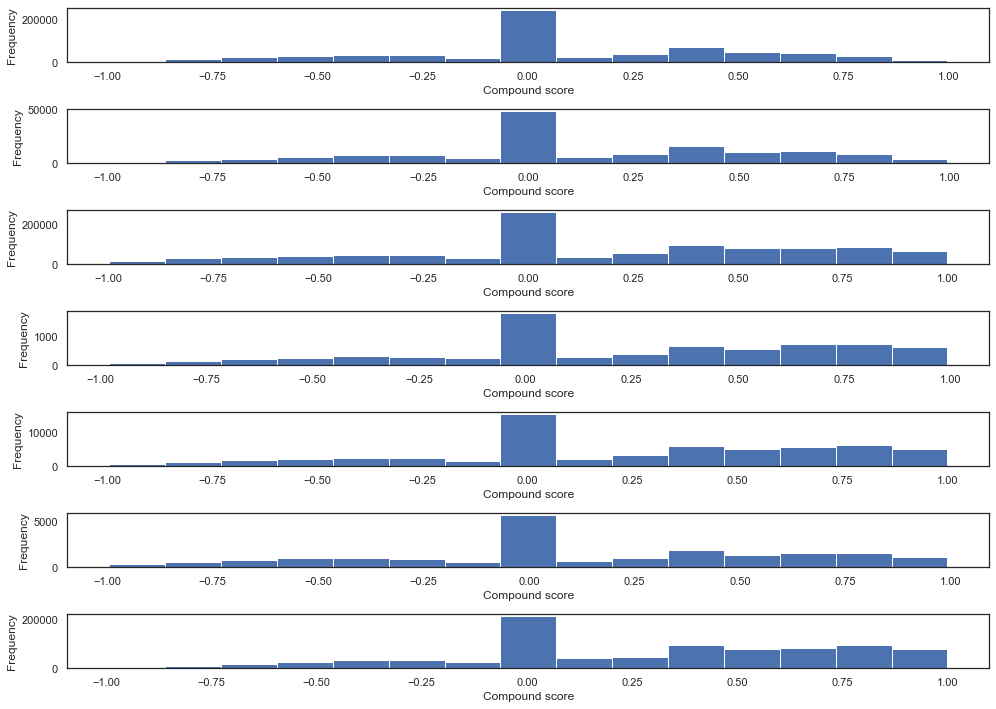

In [235]:
#Plotting the compound score distributions of the outlet selection

fig, ax = plt.subplots(7,1, figsize=(14,10))

ax[0].hist(nytimes.compound, bins=15)
ax[0].set_xlabel('Compound score')
ax[0].set_ylabel('Frequency')
ax[1].hist(wsj.compound, bins=15)
ax[1].set_xlabel('Compound score')
ax[1].set_ylabel('Frequency')
ax[2].hist(people.compound, bins = 15)
ax[2].set_xlabel('Compound score')
ax[2].set_ylabel('Frequency')
ax[3].hist(womansday.compound, bins = 15)
ax[3].set_xlabel('Compound score')
ax[3].set_ylabel('Frequency')
ax[4].hist(mtv.compound, bins = 15)
ax[4].set_xlabel('Compound score')
ax[4].set_ylabel('Frequency')
ax[5].hist(tmz.compound, bins = 15)
ax[5].set_xlabel('Compound score')
ax[5].set_ylabel('Frequency')
ax[6].hist(espn.compound, bins = 15)
ax[6].set_xlabel('Compound score')
ax[6].set_ylabel('Frequency')

fig.tight_layout()

plt.show()

Text(0.5, 1.0, '')

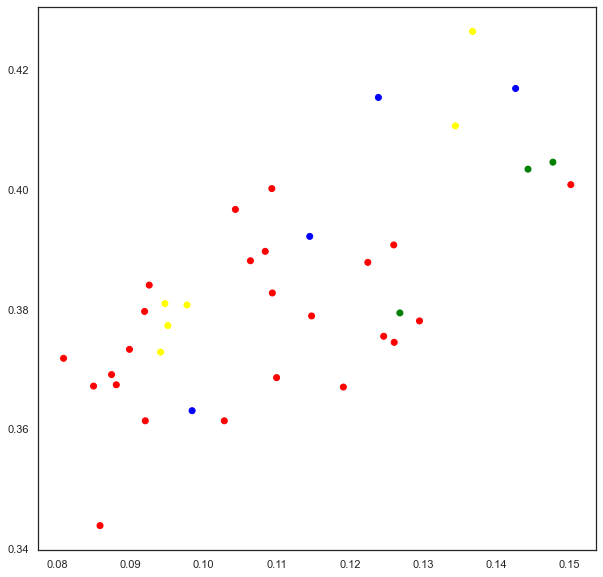

In [236]:
mean_polar = df.groupby(by = ['media_outlet'])['blob_polar'].mean()
mean_subj = df.groupby(by = ['media_outlet'])['blob_subj'].mean()


name = mean_polar.keys()

def pltcolor(lst):
    cols=[]
    for l in lst:
        if (l in newspapers):
            cols.append('red')
        elif (l in celebmagazines):
            cols.append('blue')
        elif (l in other):
            cols.append('yellow')
        else:
            cols.append('green')
    return cols
# Create the colors list using the function above
cols=pltcolor(mean_polar.keys())

fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(mean_polar, mean_subj, c=cols)
for i, txt in enumerate(name):
    ax.annotate(txt, (mean_subj[i], mean_polar[i]))
ax.set_title('')


In [237]:
df_scatter = pd.DataFrame()
df_scatter['numquotes'] = df.groupby(by = ['media_outlet'])['media_outlet'].count()
df_scatter['Polarity'] = df.groupby(by = ['media_outlet'])['compound'].mean()
df_scatter['Subjectivity'] = df.groupby(by = ['media_outlet'])['blob_subj'].mean()
df_scatter['media_outlet'] = df_scatter.index
df_scatter['category'] = df_scatter.apply(add_category, axis=1)

In [238]:
fig = px.scatter(df_scatter, x='Polarity', y = 'Subjectivity', color='category', size='numquotes', text='media_outlet')
fig.update_layout(title = 'Average polarity and subjectivity per media outlet')
fig.update_traces(textposition="bottom right")
fig.show()
fig.write_html('images/scatterplot_medias.html')


## T-testing for polarity scores

In [239]:
print(nytimes.compound.mean())
print(womansday.compound.mean())
print(wsj.compound.mean())
print(espn.compound.mean())

0.08528024693197732
0.22793258081752665
0.12814827169577306
0.27825008719375127


In [240]:
t, p = stats.ttest_ind(nytimes['compound'], wsj['compound'], equal_var=False)
print("Two sided paired t-test with null hypothesis: The mean mood in NYtimes equals the mean mood in Wall Street Journal:")
print(f"t-value: {t}, p-value: {p}")

Two sided paired t-test with null hypothesis: The mean mood in NYtimes equals the mean mood in Wall Street Journal:
t-value: -35.834473757551145, p-value: 2.1812370930100076e-280


In [241]:
t, p = stats.ttest_ind(nytimes['compound'], espn['compound'], equal_var=False)
print("Two sided paired t-test with null hypothesis: The mean mood in NYtimes equals the mean mood in ESPN:")
print(f"t-value: {t}, p-value: {p}")

Two sided paired t-test with null hypothesis: The mean mood in NYtimes equals the mean mood in ESPN:
t-value: -282.18957162795226, p-value: 0.0


In [312]:
t, p = stats.ttest_ind(nytimes['compound'], womansday['compound'], equal_var=False)
print("Two sided paired t-test with null hypothesis: The mean mood in NYtimes equals the mean mood in ESPN:")
print(f"t-value: {t}, p-value: {p}")

Two sided paired t-test with null hypothesis: The mean mood in NYtimes equals the mean mood in ESPN:
t-value: -25.90305738105446, p-value: 7.535646575194922e-142


In [242]:
t, p = stats.ttest_ind(nytimes['blob_polar'], espn['blob_polar'], equal_var=False)
print("Two sided paired t-test with null hypothesis: The mean blob polar score in NYtimes equals the mean mood in ESPN:")
print(f"t-value: {t}, p-value: {p}")

Two sided paired t-test with null hypothesis: The mean blob polar score in NYtimes equals the mean mood in ESPN:
t-value: -142.41662557831026, p-value: 0.0


In [301]:
df['category'] = df.apply(add_category, axis=1)

In [307]:
df.head()

,media_outlet,compound,positive,negative,blob_polar,blob_subj,date_short,category
0,washingtonpost,0.2500,0.083,0.000,0.000000,0.000000,2015-12-13,Newspaper
1,startribune,0.0000,0.000,0.000,0.062500,0.354167,2015-10-02,Newspaper
2,mtv,0.0000,0.000,0.000,-0.083333,0.216667,2015-10-09,Other
3,express,-0.3400,0.073,0.094,0.600000,1.000000,2015-11-17,Newspaper
4,reuters,-0.2732,0.000,0.110,-0.187500,0.500000,2015-02-06,Newspaper


In [308]:
t, p = stats.ttest_ind(df.loc[df['category'] == 'Newspaper'].compound, df.loc[df['category'] == 'Sports'].compound, equal_var=False)
print("Two sided paired t-test with null hypothesis: The mean blob polar score in NYtimes equals the mean mood in ESPN:")
print(f"t-value: {t}, p-value: {p}")

Two sided paired t-test with null hypothesis: The mean blob polar score in NYtimes equals the mean mood in ESPN:
t-value: -290.27011618667115, p-value: 0.0


In [309]:
t, p = stats.ttest_ind(df.loc[df['category'] == 'Newspaper'].compound, df.loc[df['category'] == 'Celebrity magazine'].compound, equal_var=False)
print("Two sided paired t-test with null hypothesis: The mean blob polar score in NYtimes equals the mean mood in ESPN:")
print(f"t-value: {t}, p-value: {p}")

Two sided paired t-test with null hypothesis: The mean blob polar score in NYtimes equals the mean mood in ESPN:
t-value: -66.56030181078874, p-value: 0.0


In [311]:
t, p = stats.ttest_ind(df.loc[df['category'] == 'Other'].compound, df.loc[df['category'] == 'Celebrity magazine'].compound, equal_var=False)
print("Two sided paired t-test with null hypothesis: The mean blob polar score in NYtimes equals the mean mood in ESPN:")
print(f"t-value: {t}, p-value: {p}")

Two sided paired t-test with null hypothesis: The mean blob polar score in NYtimes equals the mean mood in ESPN:
t-value: -76.27134646588573, p-value: 0.0


## Plotting distributions

In [260]:
#Making a datafram with rounded scores to ease plotting

df_rounded = df.copy()
df_rounded['compound'] = df_rounded['compound'].apply(lambda x: round(x, 2))
df_rounded['blob_polar'] = df_rounded['blob_polar'].apply(lambda x: round(x, 2))
df_rounded['blob_subj'] = df_rounded['blob_subj'].apply(lambda x: round(x, 2))
df_rounded['category'] = df_rounded.apply(add_category, axis=1)
df_rounded

,media_outlet,compound,positive,negative,blob_polar,blob_subj,date_short,category
0,washingtonpost,0.25,0.083,0.000,0.00,0.00,2015-12-13,Newspaper
1,startribune,0.00,0.000,0.000,0.06,0.35,2015-10-02,Newspaper
2,mtv,0.00,0.000,0.000,-0.08,0.22,2015-10-09,Other
3,express,-0.34,0.073,0.094,0.60,1.00,2015-11-17,Newspaper
4,reuters,-0.27,0.000,0.110,-0.19,0.50,2015-02-06,Newspaper
...,...,...,...,...,...,...,...,...
607108,express,0.30,0.151,0.000,-0.08,0.70,2020-03-08,Newspaper
607109,espn,0.75,0.145,0.033,0.26,0.32,2020-03-02,Sports
607110,mirror,0.00,0.000,0.000,0.00,0.00,2020-01-13,Newspaper
607111,latimes,-0.13,0.000,0.097,-0.39,0.83,2020-02-22,Newspaper


In [261]:
# Sorting the rows by category, counting frequecy per blob_polar value

df_blob = df_rounded.groupby(['category', 'blob_polar']).agg({'blob_polar': 'count'}).rename(columns={'blob_polar': 'count'}).reset_index()
df_blob


,category,blob_polar,count
0,Celebrity magazine,-1.00,3205
1,Celebrity magazine,-0.99,2
2,Celebrity magazine,-0.98,12
3,Celebrity magazine,-0.97,35
4,Celebrity magazine,-0.96,2
...,...,...,...
791,Sports,0.94,5
792,Sports,0.95,109
793,Sports,0.97,37
794,Sports,0.98,7


In [262]:
# Making dictionaries with count of the blob_scores

media_list = ['Sports', 'Newspaper','Celebrity magazine', 'Other' ]
array_dict = {}
for outlet in media_list:
    array_dict[f'x_{outlet}'] = df_blob[df_blob['category']==outlet]['blob_polar'] # storing the blob_polar values for all categories
    array_dict[f'y_{outlet}'] = np.log(df_blob[df_blob['category']==outlet]['count']) # storing the count of blob_polar values
    array_dict[f'y_{outlet}'] = (array_dict[f'y_{outlet}'] - array_dict[f'y_{outlet}'].min()) \
                                / (array_dict[f'y_{outlet}'].max() - array_dict[f'y_{outlet}'].min())

In [263]:
# Making ridge plot of the blob_polar distributions per category

import plotly.graph_objects as go
fig = go.Figure()
for index, media in enumerate(media_list):
    fig.add_trace(go.Scatter(
                            x=[-1, 1], y=np.full(5, len(media_list)-index),
                            mode='lines',
                            line_color='white'))
    
    fig.add_trace(go.Scatter(
                            x=array_dict[f'x_{media}'],
                            y=array_dict[f'y_{media}'] + (len(media_list)-index) ,
                            fill='tonexty',
                            name=f'{media}'))
    
    # Adding text to figure
    fig.add_annotation(
                        x=-0.1,
                        y=len(media_list)-index,
                        text=f'{media}',
                        showarrow=False,
                        yshift=1)

# figure and legend titles
fig.update_layout(
                title='Distribution of compound score',
                showlegend=False,
                xaxis=dict(title='Compound score'),
                yaxis=dict(showticklabels=False) # that way you hide the y axis ticks labels
                )

fig.show()
fig.write_html("images/polarity_blob_categories.html")

In [264]:
df_compound = df_rounded.copy()

In [265]:
df_compound = df_compound.groupby(['category', 'compound']).agg({'compound': 'count'}).rename(columns={'compound': 'count'}).reset_index()
df_compound

,category,compound,count
0,Celebrity magazine,-1.00,12
1,Celebrity magazine,-0.99,124
2,Celebrity magazine,-0.98,351
3,Celebrity magazine,-0.97,594
4,Celebrity magazine,-0.96,843
...,...,...,...
798,Sports,0.96,6677
799,Sports,0.97,5424
800,Sports,0.98,3552
801,Sports,0.99,1395


In [266]:
categories = ['Sports', 'Newspaper','Celebrity magazine', 'Other' ]

array_dict_2 = {}
for outlet in categories:
    array_dict_2[f'x_{outlet}'] = df_compound[df_compound['category']==outlet]['compound'] # storing the blob_polar values for each category
    array_dict_2[f'y_{outlet}'] = np.log(df_compound[df_compound['category']==outlet]['count']) # storing the blob_polar count for each value
    array_dict_2[f'y_{outlet}'] = (array_dict_2[f'y_{outlet}'] - array_dict_2[f'y_{outlet}'].min()) \
                                / (array_dict_2[f'y_{outlet}'].max() - array_dict_2[f'y_{outlet}'].min())

In [267]:
import plotly.graph_objects as go
fig = go.Figure()
for index, media in enumerate(categories):
    
    fig.add_trace(go.Scatter(
                            x=[-1, 1], y=np.full(5, len(categories)-index),
                            mode='lines',
                            line_color='white'))
    fig.add_trace(go.Scatter(
                            x=array_dict_2[f'x_{media}'],
                            y=array_dict_2[f'y_{media}']+ (len(categories)-index) ,
                            fill='tonexty',
                            name=f'{media}'))


    fig.add_annotation(
                        x=-0.1,
                        y=len(categories)-index,
                        text=f'{media}',
                        showarrow=False,
                        yshift=1)

# here you can modify the figure and the legend titles
fig.update_layout(
                title='Distribution of compound score',
                showlegend=False,
                xaxis=dict(title='Compound score'),
                yaxis=dict(showticklabels=False) # that way you hide the y axis ticks labels
                )

fig.show()
fig.write_html("images/polarity_distribution_categories.html")

In [268]:
chosen_news = ['nytimes', 'espn', 'womansday', 'foxnews', 'cnn', 'mtv', 'wsj']

df_news_compound = df_rounded.copy()
df_news_compound['compound'] = df_news_compound['compound'].apply(lambda x: round(x, 1))
df_news_compound = df_news_compound.groupby(['media_outlet', 'compound']).agg({'compound': 'count'}).rename(columns={'compound': 'count'}).reset_index()


array_dict_3 = {}
for outlet in chosen_news:
    array_dict_3[f'x_{outlet}'] = df_news_compound[df_news_compound['media_outlet']==outlet]['compound'] # storing the blob_polar values for each category
    array_dict_3[f'y_{outlet}'] = np.log(df_news_compound[df_news_compound['media_outlet']==outlet]['count']) # # storing the blob_polar count for each value
    array_dict_3[f'y_{outlet}'] = (array_dict_3[f'y_{outlet}'] - array_dict_3[f'y_{outlet}'].min()) \
                                / (array_dict_3[f'y_{outlet}'].max() - array_dict_3[f'y_{outlet}'].min())

In [269]:
import plotly.graph_objects as go
fig = go.Figure()
for index, media in enumerate(chosen_news):
    fig.add_trace(go.Scatter(
                            x=[-1, 1], y=np.full(5, len(chosen_news)-index),
                            mode='lines',
                            line_color='white'))
    
    fig.add_trace(go.Scatter(
                            x=array_dict_3[f'x_{media}'],
                            y=array_dict_3[f'y_{media}'] + (len(chosen_news)-index) ,
                            fill='tonexty',
                            name=f'{media}'))
    
    # plotly.graph_objects' way of adding text to a figure
    fig.add_annotation(
                        x=-0.1,
                        y=len(chosen_news)-index,
                        text=f'{media}',
                        showarrow=False,
                        yshift=1)

# here you can modify the figure and the legend titles
fig.update_layout(
                title='Distribution of compound score',
                showlegend=False,
                xaxis=dict(title='Compound score'),
                yaxis=dict(showticklabels=False) # that way you hide the y axis ticks labels
                )

fig.show()
fig.write_html("images/polarity_distribution_medias.html")

In [270]:

fig = go.Figure()
text = []
for index, media in enumerate(chosen_news):

    fig.update_layout(clickmode='event+select')
    

    
    fig.add_trace(go.Scatter(
                            x=array_dict_3[f'x_{media}'],
                            y=array_dict_3[f'y_{media}'] ,
                            #fill='tonexty',
                            name=f'{media}'))

# Modify the figure and the legend titles
fig.update_layout(
                title='Distribution of compound score',
                showlegend=True,
                xaxis=dict(title='Compound score'),
                yaxis=dict(showticklabels=False) # that way you hide the y axis ticks labels
                )

fig.show()
fig.write_html("images/polarity_distribution_media.html")

In [271]:
df_rounded

,media_outlet,compound,positive,negative,blob_polar,blob_subj,date_short,category
0,washingtonpost,0.25,0.083,0.000,0.00,0.00,2015-12-13,Newspaper
1,startribune,0.00,0.000,0.000,0.06,0.35,2015-10-02,Newspaper
2,mtv,0.00,0.000,0.000,-0.08,0.22,2015-10-09,Other
3,express,-0.34,0.073,0.094,0.60,1.00,2015-11-17,Newspaper
4,reuters,-0.27,0.000,0.110,-0.19,0.50,2015-02-06,Newspaper
...,...,...,...,...,...,...,...,...
607108,express,0.30,0.151,0.000,-0.08,0.70,2020-03-08,Newspaper
607109,espn,0.75,0.145,0.033,0.26,0.32,2020-03-02,Sports
607110,mirror,0.00,0.000,0.000,0.00,0.00,2020-01-13,Newspaper
607111,latimes,-0.13,0.000,0.097,-0.39,0.83,2020-02-22,Newspaper


In [284]:
df_categories_compound = df_rounded.copy()
df_categories_compound['compound'] = df_categories_compound['compound'].apply(lambda x: round(x, 1))
df_categories_compound = df_categories_compound.groupby(['category', 'compound']).agg({'compound': 'count'}).rename(columns={'compound': 'count'}).reset_index()

array_dict_3 = {}
for outlet in categories:
    array_dict_3[f'x_{outlet}'] = df_categories_compound[df_categories_compound['category']==outlet]['compound'] # storing the blob_polar values for each category
    array_dict_3[f'y_{outlet}'] = np.log(df_categories_compound[df_categories_compound['category']==outlet]['count']) # storing the blob_polar counts for each value
    array_dict_3[f'y_{outlet}'] = (array_dict_3[f'y_{outlet}'] - array_dict_3[f'y_{outlet}'].min()) \
                                / (array_dict_3[f'y_{outlet}'].max() - array_dict_3[f'y_{outlet}'].min())

In [285]:

fig = go.Figure()
text = []
for index, media in enumerate(categories):

    fig.update_layout(clickmode='event+select')
    

    
    fig.add_trace(go.Scatter(
                            x=array_dict_3[f'x_{media}'],
                            y=array_dict_3[f'y_{media}'] ,
                            #fill='tonexty',
                            name=f'{media}'))

# Modify the figure and the legend titles
fig.update_layout(
                title='Distribution of compound score',
                showlegend=True,
                xaxis=dict(title='Compound score'),
                yaxis=dict(showticklabels=False) # that way you hide the y axis ticks labels
                )

fig.show()
fig.write_html("images/polarity_distribution_categories_same_plot.html")



In [292]:
df_blob_subj = df_rounded.copy()
df_blob_subj = df_rounded.groupby(['category', 'blob_subj']).agg({'blob_subj': 'count'}).rename(columns={'blob_subj': 'count'}).reset_index()

array_dict_4 = {}
for outlet in categories:
    array_dict_4[f'x_{outlet}'] = df_blob_subj[df_blob_subj['category']==outlet]['blob_subj'] # storing the blob_polar values for each category
    array_dict_4[f'y_{outlet}'] = np.log(df_blob_subj[df_blob_subj['category']==outlet]['count']) # storing the blob_polar counts for each value
    #array_dict_3[f'y_{outlet}'] = (array_dict_3[f'y_{outlet}'] - array_dict_3[f'y_{outlet}'].min()) \
    #                            / (array_dict_3[f'y_{outlet}'].max() - array_dict_3[f'y_{outlet}'].min())

df_blob_subj

,category,blob_subj,count
0,Celebrity magazine,0.00,273580
1,Celebrity magazine,0.01,11
2,Celebrity magazine,0.02,128
3,Celebrity magazine,0.03,1400
4,Celebrity magazine,0.04,227
...,...,...,...
399,Sports,0.96,126
400,Sports,0.97,646
401,Sports,0.98,46
402,Sports,0.99,40


In [297]:
array_dict_3

{'x_Sports': 303    0.00
 304    0.01
 305    0.02
 306    0.03
 307    0.04
        ... 
 399    0.96
 400    0.97
 401    0.98
 402    0.99
 403    1.00
 Name: blob_subj, Length: 101, dtype: float64,
 'y_Sports': 303    12.240972
 304     1.609438
 305     4.406719
 306     6.675823
 307     4.976734
          ...    
 399     4.836282
 400     6.470800
 401     3.828641
 402     3.688879
 403    10.440069
 Name: count, Length: 101, dtype: float64,
 'x_Newspaper': 101    0.00
 102    0.01
 103    0.02
 104    0.03
 105    0.04
        ... 
 197    0.96
 198    0.97
 199    0.98
 200    0.99
 201    1.00
 Name: blob_subj, Length: 101, dtype: float64,
 'y_Newspaper': 101    14.628020
 102     4.127134
 103     7.168580
 104     9.371353
 105     7.593878
          ...    
 197     6.891626
 198     8.903136
 199     6.442540
 200     6.054439
 201    12.898224
 Name: count, Length: 101, dtype: float64,
 'x_Celebrity magazine': 0      0.00
 1      0.01
 2      0.02
 3      0.03
 4      

In [293]:

fig = go.Figure()
text = []
for index, media in enumerate(categories):

    fig.update_layout(clickmode='event+select')
    

    
    fig.add_trace(go.Scatter(
                            x=array_dict_4[f'x_{media}'],
                            y=array_dict_4[f'y_{media}'] ,
                            #fill='tonexty',
                            name=f'{media}'))

# Modify the figure and the legend titles
fig.update_layout(
                title='Distribution of compound score',
                showlegend=True,
                xaxis=dict(title='Subjectivity score'),
                yaxis=dict(showticklabels=False) # that way you hide the y axis ticks labels
                )

fig.show()
fig.write_html("images/subj_distribution_categories_same_plot.html")

In [283]:
df_rounded.groupby(by = 'category').agg('mean')

,compound,positive,negative,blob_polar,blob_subj
category,,,,,
Celebrity magazine,0.171261,0.130968,0.067232,0.116269,0.393578
Newspaper,0.139339,0.121508,0.069086,0.102639,0.378528
Other,0.123469,0.116649,0.071154,0.097515,0.379382
Sports,0.276404,0.145125,0.049858,0.147484,0.404395


## Det nedenfor skal antagelig ikke med

In [ ]:
'''
Blir for stort


import plotly.figure_factory as ff


t = np.linspace(-1, 1.2, 2000)
x = nytimes['blob_polar']
y = nytimes['blob_subj']

colorscale = ['#7A4579', '#D56073', 'rgb(236,158,105)', (1, 1, 0.2), (0.98,0.98,0.98)]

fig = ff.create_2d_density(
    x, y, colorscale=colorscale,
    hist_color='rgb(255, 237, 222)', point_size=3
)
fig.write_html("images/nytimes_scatter.html")
'''

'\nBlir for stort\n\n\nimport plotly.figure_factory as ff\n\n\nt = np.linspace(-1, 1.2, 2000)\nx = nytimes[\'blob_polar\']\ny = nytimes[\'blob_subj\']\n\ncolorscale = [\'#7A4579\', \'#D56073\', \'rgb(236,158,105)\', (1, 1, 0.2), (0.98,0.98,0.98)]\n\nfig = ff.create_2d_density(\n    x, y, colorscale=colorscale,\n    hist_color=\'rgb(255, 237, 222)\', point_size=3\n)\nfig.write_html("images/nytimes_scatter.html")\n'

In [ ]:


#Bevegelig plot. Skal antagelig ikke med

import plotly.express as px

per_day = df_rounded.copy()
#per_day['month_year'] = per_day['date_short'].apply(lambda x: pd.to_datetime(x).to_period('M'))
per_day = per_day.groupby(['date_short', 'media_outlet']).agg('mean').reset_index()
per_day = per_day[per_day['date_short'] > '2019-01-01']

per_day['blob_subj'] = per_day['blob_subj'] 
per_day['blob_polar'] = per_day['blob_polar'] 

per_day

,date_short,media_outlet,compound,positive,negative,blob_polar,blob_subj
41630,2019-01-02,aarp,0.120000,0.117000,0.031750,0.002500,0.427407
41631,2019-01-02,bbc,0.142252,0.116685,0.058009,0.086216,0.367131
41632,2019-01-02,cnn,0.150028,0.123425,0.070615,0.098464,0.364463
41633,2019-01-02,dailymail,0.243810,0.128786,0.062500,0.137857,0.323336
41634,2019-01-02,economist,-0.082222,0.117889,0.114222,0.113333,0.395062
...,...,...,...,...,...,...,...
55674,2020-04-16,usatoday,0.325833,0.132917,0.064833,0.110833,0.382791
55675,2020-04-16,usmagazine,0.253014,0.158603,0.071658,0.116301,0.454472
55676,2020-04-16,usnews,0.302500,0.161000,0.055500,0.000000,0.220833
55677,2020-04-16,vanityfair,0.140444,0.104533,0.071933,0.065333,0.455057


In [ ]:
fig = px.scatter(per_day, x="blob_polar", y="blob_subj", animation_frame= "date_short", animation_group="media_outlet",
        color="media_outlet", hover_name="media_outlet",
           log_x=True, size_max=0.1, range_x=[0.01,1], range_y=[0.01,1])
fig.write_html("images/wsj_moving.html")

import plotly.figure_factory as ff


t = np.linspace(-1, 1.2, 2000)
x = nytimes['blob_polar']
y = nytimes['blob_subj']

colorscale = ['#7A4579', '#D56073', 'rgb(236,158,105)', (1, 1, 0.2), (0.98,0.98,0.98)]

fig = ff.create_2d_density(
    x, y, colorscale=colorscale,
    hist_color='rgb(255, 237, 222)', point_size=3
)
fig.write_html("images/scatterplot_n")
